# MSDS Machine Learning 365 Machine Learning 1
# Mini_Lab_Resubmission
# Project Team: David Loveday, Katherine Lockard, Roger Tchegui

# CREATE MODELS 1


## BUSINESS UNDERSTANDING 1.1

### Introduction 1.1.1
The Paralyzed Veterans of America (PVA), a congressionally chartered veterans service organization, was founded in 1946 and continues to provide services and advocacy for disabled veterans today. While the organization does receive limited federal funds, private donations have allowed their service capabilities to expand well beyond that which those limited public funds would allow. For the PVA to meet its annual expenses and ambitious service offerings, they must regularly conduct marketing campaigns to seek new and maintain their existing donor base.

Over it’s life, the PVA has collected much information about the characteristics of the individuals who donate including traditional & intuitive demographic information such as location of residence, number of children, and number of military veterans in their families. In addition, the PVA has also collected extensive information concerning an individual’s donation patterns and their response to specific past mass marketing campaigns.

### Project Objectives 1.1.2
We intend to study the potential predictive power for which these donor characteristics data allow, if any, towards classifying if an individual will contribute to the most recent marketing campaign.  Logistic Regression (LR) and Support Vector Machine (SVM) methods will be evaluated and compared.  The binary response variable is highly imbalanced (donate (5%) vs not-donate (95%)) and will need to be addressed to understand model performance.  The team will explore balancing strategies during test/train splits, as well as considering more appropriate metrics like precision, recall and f-measure.

### Project Plan & Workflow 1.1.3
This general workflow was employed by the research team and documented in the report to follow:
1.  Cleanse and pre-process data
2.	Construct logistic regression model (80%-20% train/test split) which incorporates all 418 features and honors the imbalance of the as-delivered dataset.
3.	Construct logistic regression model (80%-20% train/test split) which incorporates all 418 features but now seeks to balance the training data via class weightings.
4.	Explore incremental logistic regression model improvement through feature exclusion to remove features of little importance or those showing strong correlation via importance coefficients derived from (2) above.  Note that extensive testing showed no performance improvement.
5.	Explore incremental logistic regression model improvement by manually changing hyper parameters and through grid search optimization.
6.	Compare stochastic gradient descent fit speed versus the gradient descent methods in (1), (2) and (3) as this dataset is rather large (>90,000 rows, >400 columns).
7.	Construct Support Vector Machine (SVM) model using (80%-20% train/test split) which incorporates all 418 features with the balanced training data used in (2). Extensive testing showed that Stochastic Gradient Descent must be employed given the size of the dataset.
8.  Explore incremental SVM model improvement through feature exclusion to remove features of little importance or those showing strong correlation via importance coefficients derived from (7) above.  Note that extensive testing showed no performance improvement.
9. Explore incremental model improvement by manually changing SVM hyper parameters

After all models have been constructed and typical performance metrics compared, the team will discuss interpretations of coefficient weightings from the preferred logistic regression models as well as the support vectors from the SVM model.


In [ ]:
## Import librairies 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# setting the random_seed
RANDOM_SEED = 0

In [ ]:
## Reading the initial dataset
#data = pd.read_csv('C:\\Users\\tcheg\\OneDrive\\Documents\\Marchine Learning 1\\cup98Train.txt', sep = ',')
#data = pd.read_csv('C:\\Users\\Dave Loveday\\Southern Methodist University\\365_Machine Learning I - General\\Project 1\\Raw Data\\cup98Train.txt', sep = ',')
data = pd.read_csv('/content/drive/MyDrive/cup98Train.txt', sep = ',')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## DATA UNDERSTANDING 1.2

### Data Summary 1.2.1
The dataset provided is quite rich in both individuals and their associated features/characteristics with a healthy mix of both continuous and categorical features.

Below we see that the raw datset, as provided in csv form from the PVA, has 95,412 rows (each representing an individual donor) with 481 features.

Of those features: 310 are integers (int64) 97 are real numbers (float64) 74 are string categorical values (object).


In [ ]:
### Data Summary 1.2.1
# Raw dataset shape and typing

print( data.info() )
print( data.dtypes.value_counts() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 481 entries, ODATEDW to GEOCODE2
dtypes: float64(97), int64(310), object(74)
memory usage: 350.1+ MB
None
int64      310
float64     97
object      74
dtype: int64


### Data Description 1.2.2

#### Explanatory Feature Discussion 1.2.2.1
While the total number of delivered features is overwhelming, after inspection, we can group subsets in to a more managable number of over-arching categories:
1. Unique identifier (1 feature - continious) - 'CONTROLN' feature which houses a unique integer for each individual donor where values only occur once.<br>
<br>
2. Source of internal PVA data (2 features - categorical) - how/where/when the particular feature was captured<br>
Examples:<br>
     'ODATEDW' - Date of donor's first gift to PVA YYMM format (Year/Month) (Date)<br>
     'OSOURCE' - Code indicating which mailing list the donor was originally acquired from (Categorical)<br>
<br>
3. Personal characteristics collected by PVA (28 features - categorical/continious/dates) - includes specific demographic information of an individual like zipcode of residence, age, number of children, homeownership...<br>
Examples:<br>
     'NUMCHLD' - Number of children in household (Integer)<br>
     'INCOME' - Household income (Integer)<br>
     'GENDER' - Gender of individual (Categorical)<br>
<br>
4. Information sourced from 3rd parties (46 features - categorical/continious) - PVA has acquired commerically available consumer data from vendors MetroMail & Polk which captures information about individuals response to other mail solicitations and publically available civil employment information<br>
Examples:<br>
     'MBGARDEN' - Number of know times the donor responded to mail offers to gardening publications (Integer)<br>
     'PUBPHOTO' - Number of know times the donor responded to mail offers to photography publications (Integer)<br>
     'FEDGOV' - % of household employed by the federal government (Integer %)<br>
<br>
5. Census data (271 features - continious) - features which reflect characteristics of the donors neightboorhood as collected by the 1990 US Census<br>
Examples:<br>
     'POP90C1' - Percent population in urbanized area (Integer %)<br>
     'AGE901' - Median age of population (Integer)<br>
     'HHN3' - Percent 3 or more person households (Integer %)<br>
     'EIC3' - Percent employed in construction industry (Integer %)<br>
<br>
6. PVA Specific Giving History (117 features - continious/categorical/dates) - features which reflect four different details about a donor's participation (or lack thereof) in specific previous marketing campaigns by PVA. Note there are 22 unique marketing campaigns captured in this dataset.<br>
Examples:<br>
     'ADATE_3' - Date the 96NK promotion was mailed to donor (Date YYMM)<br>
     'RFA_3' - Donor's status as of 96NK promotion date (Categorical)<br>
     'RDATE_3' - Date the donor's gift was received for 96NK (Date YYMM)<br>
     'RAMNT_3' - Dollar amount of the gift for 96NK (Integer USD)<br>
<br>
7. PVA Aggregate Giving History (17 features - continous/categorical/date) - features which reflect the aggregate giving history of a donor<br>
Examples:<br>
     'RAMNTALL' - Dollar amount of lifetime gifts to date (Integer USD)<br>
     'MINRAMNT' - Dollar amount of smallest gift to date (Integer USD)<br>
     'MINRDATE' - Date assoicated with the smallest gift to date<br>
     'FISTDATE' - Date of first gift made by donor (Date YYMM)<br>
     'NEXTDATE' - Date of second gift made by donor (Date YYMM)<br>


### Data Description 1.2.2 (continued)

#### Response Feature Discussion 1.2.2.2

The response variable, also called the "TARGET" throughout this report, is a binary indicator which records an individuals response response to the 97NK mail marketing campaign. Unfortunately, there was no detailed provided about this particular campaign.  This variable will be the focus of our predicitive modeling effort and against whom we shall judge performance.

The highly imbalanced nature of this feature presents material challanges and will be discussed in much detail in this report.  See counts of each binary occurance in the bar chart below where the y-axis captures the total instance count for each occurance.

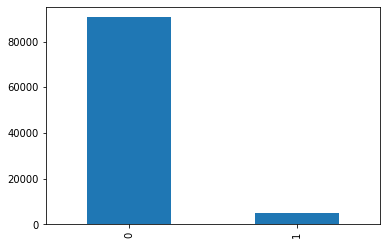

In [ ]:
data['TARGET_B'].value_counts(sort=False).plot.bar()

## DATA PREPARATION 1.3

 Pre-processing steps include:
1)	Elimination of all features that had more than 25% of values missing.<br>
2)	Identification of all features which were delivered with seemingly continuous values but should be considered as categorical features (example: Zip codes). These were manually reclassified as such.<br>
3)	Imputation of missing values.  Continious data leveraged median values, while categorical data leveraged modes.<br>
4)  Categorical data were transformed to integer representation via one-hot encoding.<br>
5)  Scaling of data 

Feature selection was considered iteratively after inspecting feature importance weights produced by fitting models which considered all possible features.  These features of highest importance were then compared pair-wise via Pearson’s correlation coefficients to identify multi-collinearity and certain features were dropped if strong relationships existed.  Updated models were re-fit using high-graded subsets but none of these witnessed an improvement in performance.  The following report will only present the models which considered all of the available features.


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from numpy import array
from matplotlib import pyplot

# Data Preparation & Pre-processing

df = data.copy()

# Columns which are categorical and need converted to Panda's Category type variable
column_list_categorical = ['OSOURCE','GEOCODE2','CLUSTER2','HPHONE_D','TARGET_B',
                           'CONTROLN','LIFESRC','GEOCODE','WEALTH2','DATASRCE',
                           'CLUSTER','NOEXCH','ZIP','TCODE','OSOURCE', 'TCODE',
                           'STATE', 'ZIP', 'MAILCODE', 'PVASTATE', 'DOB',
                           'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'MDMAUD',
                           'DOMAIN', 'CLUSTER', 'AGEFLAG', 'HOMEOWNR', 'CHILD03', 'CHILD07',
                           'CHILD12', 'CHILD18', 'GENDER', 'DATASRCE', 'SOLP3', 'SOLIH', 'MAJOR',
                           'WEALTH2', 'GEOCODE', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE',
                           'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER',
                           'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC',
                           'PEPSTRFL', 'RFA_2', 'RFA_3', 'RFA_4', 'RFA_5', 'RFA_6', 'RFA_7',
                           'RFA_8', 'RFA_9', 'RFA_10', 'RFA_11', 'RFA_12', 'RFA_13', 'RFA_14',
                           'RFA_15', 'RFA_16', 'RFA_17', 'RFA_18', 'RFA_19', 'RFA_20', 'RFA_21',
                           'RFA_22', 'RFA_23', 'RFA_24', 'CONTROLN', 'HPHONE_D',
                           'RFA_2R', 'RFA_2A', 'MDMAUD_R', 'MDMAUD_F', 'MDMAUD_A', 'CLUSTER2',
                           'GEOCODE2']
##############################################

# Columns which need to have their null's replaced with zero's
RAMNT_to_zero = ['RAMNT_3', 'RAMNT_4', 'RAMNT_5', 'RAMNT_6', 'RAMNT_7',
                 'RAMNT_8', 'RAMNT_9', 'RAMNT_10', 'RAMNT_11', 'RAMNT_12', 'RAMNT_13',
                 'RAMNT_14', 'RAMNT_15', 'RAMNT_16', 'RAMNT_17', 'RAMNT_18', 'RAMNT_19',
                 'RAMNT_20', 'RAMNT_21', 'RAMNT_22', 'RAMNT_23', 'RAMNT_24']

df[RAMNT_to_zero] = df[RAMNT_to_zero].fillna(0)
##############################################

# Replace all null's as delivered with NaN's
df = df.replace(r'^\s*$', np.NaN, regex=True)
##############################################

# Continious columns to be imputed with median values
continious_to_impute = ['AGE', 'INCOME', 'MSA', 'ADI', 'DMA', 'ADATE_3', 'ADATE_4', 'ADATE_6',
                        'ADATE_7', 'ADATE_8', 'ADATE_9', 'ADATE_11', 'ADATE_12', 'ADATE_14',
                        'ADATE_16', 'ADATE_18', 'NEXTDATE', 'TIMELAG', 'CLUSTER2']

for col in continious_to_impute:
    df[col].fillna(df[col].median(), inplace=True)
    
##############################################

# transform the continuous variable to same scale ranges 0 to 1

from sklearn.preprocessing import MinMaxScaler

minmaxscalar = MinMaxScaler()
df[continious_to_impute] = minmaxscalar.fit_transform(df[continious_to_impute])

##############################################

# Continious columns to be imputed with mode values
categorical_to_impute = ['OSOURCE', 'NOEXCH', 'DOMAIN', 'CLUSTER', 'HOMEOWNR', 'GENDER',
                        'DATASRCE', 'RFA_3', 'RFA_4', 'RFA_6', 'RFA_7', 'RFA_8', 'RFA_9',
                        'RFA_11', 'RFA_12', 'RFA_14', 'RFA_16', 'RFA_18', 'GEOCODE2']

for col in categorical_to_impute:
    temp_mode = df[col].mode()[0]
    df[col] = df[col].replace(np.NaN, temp_mode)

##############################################

# Convert list of categorical variables to pandas category type variables
for col in column_list_categorical:
    df[col] = pd.Categorical(df[col].astype(str))
    
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))

##############################################

# Columns to totally drop as they were delivered with >25% nulls
columns_to_drop = ['NUMCHLD', 'WEALTH1', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT',
                   'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH',
                   'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'ADATE_5', 'ADATE_10',
                   'ADATE_13', 'ADATE_15', 'ADATE_17', 'ADATE_19', 'ADATE_20', 'ADATE_21',
                   'ADATE_22', 'ADATE_23', 'ADATE_24', 'RDATE_3', 'RDATE_4', 'RDATE_5',
                   'RDATE_6', 'RDATE_7', 'RDATE_8', 'RDATE_9', 'RDATE_10', 'RDATE_11',
                   'RDATE_12', 'RDATE_13', 'RDATE_14', 'RDATE_15', 'RDATE_16', 'RDATE_17',
                   'RDATE_18', 'RDATE_19', 'RDATE_20', 'RDATE_21', 'RDATE_22', 'RDATE_23',
                   'RDATE_24', 'MAILCODE', 'PVASTATE', 'RECINHSE', 'RECP3', 'RECPGVG', 
                   'RECSWEEP', 'AGEFLAG', 'CHILD03', 'CHILD07', 'CHILD12', 'CHILD18', 
                   'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2', 'GEOCODE', 'COLLECT1', 'VETERANS',
                   'BIBLE', 'CATLG','HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS',
                   'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF',
                   'CARDS', 'PLATES', 'LIFESRC', 'PEPSTRFL', 'RFA_5', 'RFA_10', 'RFA_13',
                   'RFA_15', 'RFA_17', 'RFA_19', 'RFA_20', 'RFA_21', 'RFA_22', 'RFA_23',
                   'RFA_24', 'DOB']

df = df.drop(columns_to_drop, axis = 1)
##############################################

final_list_categorical_features = df[df.select_dtypes(['category']).columns].columns

final_list_categorical_features = final_list_categorical_features.drop('ZIP')
final_list_categorical_features = final_list_categorical_features.drop('CONTROLN')
final_list_categorical_features = final_list_categorical_features.drop('OSOURCE')

In [ ]:
## One-hot encoding for all categorical variables
from sklearn import preprocessing
final_df = pd.get_dummies(df[final_list_categorical_features], drop_first=True)

## Model Construction 1.3

In [ ]:
## Renaming the response variable from TARGET_B to just TARGET

final_df.rename(columns={'TARGET_B_1':'TARGET'},inplace=True)

In [ ]:
## Splitting our data into train and test using cross validation 

final_df2 = final_df.copy()

from sklearn.model_selection import ShuffleSplit

if 'TARGET' in final_df2:
    y = final_df2['TARGET'].values 
    del final_df2['TARGET'] 
    X = final_df2.values 

num_cv_iterations = 1
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2, random_state=RANDOM_SEED)
                         
print(cv_object)

ShuffleSplit(n_splits=1, random_state=0, test_size=0.2, train_size=None)


## 1.3.1 Logistic regression

In [ ]:
%%time
## Building Logistic Regression Model on imbalanced training data

from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, solver='liblinear' ) 


iter_num=0


for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
    lr_clf.fit(X_train,y_train)  
    y_hat = lr_clf.predict(X_test) 
    

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    print('Precision Score: ', precision_score(y_true=y_test,y_pred=y_hat))
    print('Recall Score: ', recall_score(y_true=y_test,y_pred=y_hat))
    print('F1 Score: ', f1_score(y_true=y_test,y_pred=y_hat))
    iter_num+=1
    

====Iteration 0  ====
accuracy 0.9475973379447676
confusion matrix
 [[18083     0]
 [ 1000     0]]
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0
CPU times: user 5.11 s, sys: 305 ms, total: 5.42 s
Wall time: 5.32 s


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see that using stratified training data, or in other words, training data which reflects the imbalance of the raw dataset, our models have virtually no predictive power.  The model predicts all instances to NOT make a donation... which yields a very high accuracy score but that accuracy is simply a reflection of the non-donor vs donor split in the raw dataset.

We will now consider other strategies to address the imbalance for test/train splits below. 

In [ ]:
# run logistic regression and vary some parameters

from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight="balanced", solver='liblinear' ) 


iter_num=1


for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
    lr_clf.fit(X_train,y_train)  
    y_hat = lr_clf.predict(X_test) 
    

    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    print('Precision Score: ', precision_score(y_true=y_test,y_pred=y_hat))
    print('Recall Score: ', recall_score(y_true=y_test,y_pred=y_hat))
    print('F1 Score: ', f1_score(y_true=y_test,y_pred=y_hat))
   


====Iteration 1  ====
accuracy 0.6218099879473877
confusion matrix
 [[11376  6707]
 [  510   490]]
Precision Score:  0.0680839238571627
Recall Score:  0.49
F1 Score:  0.11955593509820665


We getting an accuracy of ~62% with our logistic regression model after adjusting for the class weight in our dataset. We will then implement other techniques below, like gridsearch and SGD classifier, to see if we can improve the accuracy of our model.  But first let's examine the coefficient weights which our initial model has calculated.

In [ ]:
# Let's find the weights  of our logistic regression model
# Interpretation of these weights will be discussed at the end of this report

from sklearn.preprocessing import MinMaxScaler


# scale attributes by the training set
scl_obj = MinMaxScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear', class_weight="balanced") # get object
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,final_df.columns) # combine attributes
zip_vars = sorted(zip_vars)
#for coef, name in zip_vars:
#   print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.6174081643347482
[[11264  6819]
 [  482   518]]


In [ ]:
# Find the Top 25 features of Highest Importance based on absolute value of their coefficient

zip_vars_df = pd.DataFrame(zip_vars)
zip_vars_df.columns = ['Coeff', 'Feature']
zip_vars_df['Coeff'] = zip_vars_df['Coeff'].str[0]
zip_vars_df['Abs_Coeff'] = abs(zip_vars_df['Coeff'])
zip_vars_df['Frac_Weight'] = zip_vars_df['Abs_Coeff']/zip_vars_df['Abs_Coeff'].sum()


lr_zip_vars_df_1 = zip_vars_df

zip_vars_df.sort_values(by=['Abs_Coeff'], ascending = False).head(25)

,Coeff,Feature,Abs_Coeff,Frac_Weight
0,-0.706506,RFA_18_N1G,0.706506,0.003864
1,-0.700270,RFA_18_I1E,0.700270,0.003830
1397,0.643326,RFA_18_I1F,0.643326,0.003518
1396,0.615433,RFA_8_A1G,0.615433,0.003366
1395,0.613178,RFA_18_S3G,0.613178,0.003354
1394,0.600245,RFA_9_S4F,0.600245,0.003283
2,-0.587621,RFA_8_P1A,0.587621,0.003214
1393,0.579625,RFA_9_I4E,0.579625,0.003170
1392,0.568059,RFA_2_L4D,0.568059,0.003107
3,-0.548656,RFA_14_S4F,0.548656,0.003001


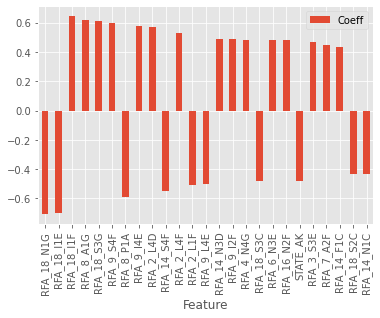

In [ ]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


#weights = pd.Series(lr_clf.coef_[0],index=final_df.columns)
zip_vars_df.sort_values(by=['Abs_Coeff'], ascending = False).head(25).plot(x = 'Feature', y = 'Coeff', kind='bar')
plt.show()

The above list is the top 25 heaviest weights, in terms of absolute value, more or less evenly split between positive and negatives.  The project team is not surprised to see that these are dominated by 'RFA' attributes which are complex categorical variables which describe the donation status of an individual at the time of a given marketing campaign.  These will be discussed in length in the results interpration at the end of this report (section 5).

## 1.3.2 SGD CLASSIFIER

In [ ]:
%%time

## Let's fit our logistic regression model using SGD Classifier 



sgd_clf = SGDClassifier(max_iter=1000, tol= 1e-3, class_weight="balanced", penalty='l2',learning_rate='optimal',
                                            eta0=0.1,early_stopping=True,alpha = 0.01,loss='log',fit_intercept=True)

iter_num=0


for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    
    sgd_clf.fit(X_train,y_train)  
    y_pred = sgd_clf.predict(X_test) 

    
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    print('Precision Score: ', precision_score(y_true=y_test,y_pred=y_pred))
    print('Recall Score: ', recall_score(y_true=y_test,y_pred=y_pred))
    print('F1 Score: ', f1_score(y_true=y_test,y_pred=y_pred))
    iter_num+=1



====Iteration 0  ====
accuracy 0.6174081643347482
confusion matrix
 [[11264  6819]
 [  482   518]]
Precision Score:  0.06768170704601023
Recall Score:  0.609
F1 Score:  0.1218243648729746
CPU times: user 6.14 s, sys: 1.42 s, total: 7.56 s
Wall time: 6.33 s


We used SGD classifier to improve the accuracy of our model and we got an accuracy of ~62%, the accuracy is not improving we will try the grisearch method 

## 1.3.3 GridSerach

In [ ]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import GridSearchCV

lr_clf = LogisticRegression(C=1.0, class_weight="balanced", solver='liblinear' ) 


iter_num=0

C=[0.001,0.01,0.1,1,10,100]


param_grid = {'C':C}


for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    grid_search_clf = GridSearchCV(estimator=lr_clf,param_grid=param_grid,cv=3)
    
    
    grid_search_clf.fit(X_train,y_train)  
    y_pred = grid_search_clf.predict(X_test) 

    
    acc = mt.accuracy_score(y_test,y_pred)
    conf = mt.confusion_matrix(y_test,y_pred)
    print("====Iteration",iter_num," ====")
    print("Best C :", grid_search_clf.best_estimator_.get_params()['C'])
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    print('Precision Score: ', precision_score(y_true=y_test,y_pred=y_pred))
    print('Recall Score: ', recall_score(y_true=y_test,y_pred=y_pred))
    print('F1 Score: ', f1_score(y_true=y_test,y_pred=y_pred))
    iter_num+=1
    


====Iteration 0  ====
Best C : 100
accuracy 0.6222292092438296
confusion matrix
 [[11387  6696]
 [  513   487]]
Precision Score:  0.06779896978978144
Recall Score:  0.487
F1 Score:  0.11902725161921059


## SVM 

In [ ]:
svm_sgd = SGDClassifier(alpha=.0001,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',class_weight = 'balanced',
        loss='hinge', n_iter_no_change=3, n_jobs=-1, penalty='l2')
alphas = [0.0001,0.001, 0.01, 0.1, 1, 10]
iterations = [1,3,5,7,9]
tuned_parameters = [{'alpha': alphas, 'n_iter_no_change':iterations}]
model = GridSearchCV(svm_sgd, tuned_parameters, scoring = 'f1')
model.fit(X_train,y_train)

GridSearchCV(estimator=SGDClassifier(class_weight='balanced', l1_ratio=0.0,
                                     n_iter_no_change=3, n_jobs=-1),
             param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                          'n_iter_no_change': [1, 3, 5, 7, 9]}],
             scoring='f1')

In [ ]:
print("Best Alpha:", model.best_estimator_.get_params()['alpha'])
print("Best n_iterations:",model.best_estimator_.get_params()['n_iter_no_change'])

Best Alpha: 0.01
Best n_iterations: 1


From the above gridsearch, we see that the best alpha value is .01 and the best number of iterations is 9 to achieve the highest f1 score. We will fit the SVM model using SGDClassifier below with these parameters.

SVM Accuracy: 0.6068228265995913
SVM Confusion Matrix
 [[11053  7030]
 [  473   527]]
Precision: 0.0697366679899431
Recall:  0.527
F1:  0.12317400958279773


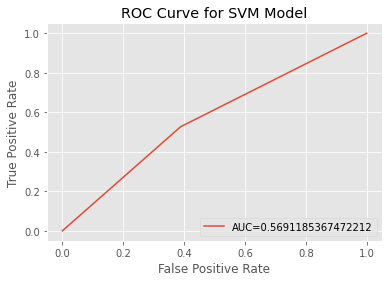

CPU times: user 11.6 s, sys: 142 ms, total: 11.8 s
Wall time: 11.7 s


In [ ]:
%%time

svm_sgd2 = SGDClassifier(alpha=.01,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',class_weight = 'balanced',
        loss='hinge', n_iter_no_change=9, n_jobs=-1, penalty='l2')


svm_sgd2.fit(scl_obj.fit_transform(X_train),y_train)
yhat = svm_sgd2.predict(scl_obj.transform(X_test))
    
conf = mt.confusion_matrix(y_test,yhat)
acc = mt.accuracy_score(y_test,yhat)

print('SVM Accuracy:', acc)
print('SVM Confusion Matrix\n', conf)
print("Precision:", mt.precision_score(y_test,yhat))
print("Recall: ", mt.recall_score(y_test, yhat))
print("F1: ", mt.f1_score(y_test, yhat))
#ROC curve for SVM, code found from statology.org
#define metrics
#y_pred_proba = log_sgd.predict(X[test_idx])#::,1]
fpr, tpr, _ = mt.roc_curve(y_test,  yhat)
auc = mt.roc_auc_score(y_test, yhat)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title("ROC Curve for SVM Model")
plt.show()

This data set was too large to train the support vector machine model without Stochastic Gradient Descent (SGD). Before training the model, the independent variables were scaled and the two classes were balanced in order to improve the quality and predictive power of the model. Due to the extreme unbalance between the two target classes in this data set, accuracy is not a good metric to rely on. The metric we focused on improving was the F1 score. Using the optimal parameters, this model yielded an F1 score of .11699, a precision score of .06623, and a recall score of .501.

Next, we will take a subset of the original dataset in order to analyze the support vectors later.

In [ ]:
#Take subset to perfrom SVM Analysis Below
#Randomly select 10k observations of dataset                         

subset = final_df.sample(n = 10000)

scaled_subset = pd.DataFrame(scl_obj.fit_transform(subset), columns = subset.columns, 
                             index = subset.index)

scaled_subset_data   = scaled_subset.copy()
scaled_subset_target = subset['TARGET']
scaled_subset_data.drop("TARGET", axis = 1,inplace = True)

X_sub = scaled_subset_data.values
y_sub  = scaled_subset_target.values

In [ ]:
from sklearn.model_selection import ShuffleSplit

num_cv_iterations = 1
num_instances = len(y_sub)
cv_object2 = ShuffleSplit(n_splits=num_cv_iterations, test_size  = 0.2, random_state=RANDOM_SEED)                      

In [ ]:
#Create training and testing sets for subset
for train_indices2, test_indices2 in cv_object2.split(X_sub,y_sub): 
    
    subset_train = X_sub[train_indices2]
    subTarget_train = y_sub[train_indices2]
    
    subset_test = X_sub[test_indices2]
    subTarget_test = y_sub[test_indices2]

In [ ]:
%%time
## SVM Model

# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.linear_model import SGDClassifier
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svc = LinearSVC(class_weight="balanced", C= 1.0, fit_intercept=True, random_state=RANDOM_SEED, max_iter = 1000)


C=[0.001,0.01,0.1,1,10,100]

param_grid = {'C':C}


iter_num=0


grid_search_clf3 = GridSearchCV(svc,param_grid=param_grid, scoring = 'f1')
    
grid_search_clf3.fit(subset_train,subTarget_train)  
y_hat3 = grid_search_clf3.predict(subset_test) 
    

acc = mt.accuracy_score(subTarget_test,y_hat3)
conf = mt.confusion_matrix(subTarget_test,y_hat3)
print("====Iteration",iter_num," ====")
print("Best C:", grid_search_clf3.best_estimator_.get_params()['C'])
print("accuracy", acc )
print("confusion matrix\n",conf)
print('Precision Score: ', precision_score(y_true=subTarget_test,y_pred=y_hat3))
print('Recall Score: ', recall_score(y_true=subTarget_test,y_pred=y_hat3))
print('F1 Score: ', f1_score(y_true=subTarget_test,y_pred=y_hat3))
iter_num+=1
    


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

====Iteration 0  ====
Best C: 0.001
accuracy 0.647
confusion matrix
 [[1236  652]
 [  54   58]]
Precision Score:  0.08169014084507042
Recall Score:  0.5178571428571429
F1 Score:  0.1411192214111922
CPU times: user 14.1 s, sys: 3.17 s, total: 17.3 s
Wall time: 13.7 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
#Training SVM model on subset of original data for support vector analysis
from sklearn.svm import SVC
svm_clf = SVC(C=.001, kernel='linear',class_weight = 'balanced') # Make Model
svm_clf.fit(subset_train, subTarget_train)  # Train Model

SVC(C=0.001, class_weight='balanced', kernel='linear')

# MODEL ADVANTAGES 2

In general, given the extreme imbalance of the dataset in question, neither Logistic Regression nor SVM tend to be high-performing predictive strategies. The models will predict negative outcomes, or non-donation, for nearly all instances when trained on the raw field data.  To achieve more interesting results, the team wass forced to use aggressive balancing techniques for testing and training splits which probably renders the final models untrustworthy.  Further, the research team has found that the logistic regression and SVM methods employed, both utilizing l2 penalization, produce comparable results with neither having a decisive advantage.  With that being directly acknowledged, there may be interpretative value in the features which these models have deemed to be of importance which will be discussed further below.

Giving the fact that we used linear kernels, both support vector machine (SVM) and linear regression (LR)  give almost identical performance and in some cases, LR will beat SVM. If the data is linearly separable in the input space, then LR is usually preferred as it outputs probabilities instead of hard labels and you can fine tune your performance by plotting the ROC curve and figuring out the right threshold.

The advantage that SVMs have over LRs is the non-linearity obtained via the use of non-linear kernels. If we compare logistic regression with SVMs with non-linear kernels, then SVMs beat LRs. If the data is linearly separable in the input space, then LRs and SVMs give comparable performance, but if the data is non-linearly separable, then LRs gradually worsen depending on how bad the non-linearity is in the data and SVMs will be preferred. 

In terms of training time or efficiency, SVMs take longer to train the model comapred to LR, and again the efficeincey just depend if we using linear kernels or non-linear kernels.

| Model | Balancing Condition | Accuracy | Precision | Recall | F1 | Hyper Parameters |
| --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | Raw/Imbalanced | | | |

# INTERPRET FEATURE IMPORTANCE 3

From the logistic regression using the balanced/stratified training set, we see the features below as being of most importance (ranked on absolute coefficient basis):

In [ ]:
lr_zip_vars_df_1.sort_values(by=['Abs_Coeff'], ascending = False).head(25)

,Coeff,Feature,Abs_Coeff,Frac_Weight
0,-0.706506,RFA_18_N1G,0.706506,0.003864
1,-0.700270,RFA_18_I1E,0.700270,0.003830
1397,0.643326,RFA_18_I1F,0.643326,0.003518
1396,0.615433,RFA_8_A1G,0.615433,0.003366
1395,0.613178,RFA_18_S3G,0.613178,0.003354
1394,0.600245,RFA_9_S4F,0.600245,0.003283
2,-0.587621,RFA_8_P1A,0.587621,0.003214
1393,0.579625,RFA_9_I4E,0.579625,0.003170
1392,0.568059,RFA_2_L4D,0.568059,0.003107
3,-0.548656,RFA_14_S4F,0.548656,0.003001


Interestingly, this feature subset is dominated (22 of 25) by “RFA” features which we will discuss below but first let’s examine the others.  We see that the potential donors who reside in the states of Alaska, Ohio and New York have negative coefficients which implies that potential donors who reside in those states, when considered in context with all the other features, have a lower probability of contributing to the target fundraising campaign.  This is certainly a phenomenon which deserves further study by PVA.

Now consider the “RFA” features which is an acronym for “Recency/Frequency/Amount” which describes the status of a donor at the time of a particular marketing campaign (first number following “RFA_”).  The last three characters are concatenations of single bytes which relate to  “Recency/Frequency/Amount”.  These follow the descriptions below:<br>
<br>
First Byte of code is concerned with RECENCY based on Date of the last Gift<br>
F=FIRST TIME DONOR; Anyone who has made their first donation in the last 6 months and has made just one donation.<br>
N=NEW DONOR Anyone who has made their first donation in the last 12 months and is not a First time donor.  This is everyone who made their first donation 7-12 months ago, or people who made their first donation between 0-6 months ago and have made 2 or more donations.<br>
A=ACTIVE DONOR Anyone who made their first donation more than 12 months ago and has made a donation in the last 12 months.<br>
L=LAPSING DONOR A previous donor who made their last donation between 13-24 months ago.<br>
I=INACTIVE DONOR A previous donor who has not made a donation in the last 24 months.  It is people who made a donation 25+ months ago.<br>
S=STAR DONOR STAR Donors are individuals who have given to 3 consecutive card mailings.<br>
<br>
Second Byte of code is concerned with FREQUENCY based on the period of recency.  The period of recency for all groups except L and I is the last 12 months.  For L it is 13-24 months ago, and for I it is 25-36 months ago.  There are four valid frequency codes:<br>
1=One gift in the period of recency<br>
2=Two gift in the period of recency<br>
3=Three gifts in the period of recency<br> 
4=Four or more gifts in the period of recency<br>

Third byte of the code is the Amount of the last gift in USD.
A=0.01  -  1.99<br>
B=2.00  -  2.99<br>
C=3.00  -  4.99<br>
D=5.00  -  9.99<br>
E=10.00 - 14.99<br>
F=15.00 - 24.99<br>
G=25.00 and above<br>
<br>
Clearly, much useful information is contained in these features and we shall explicitly interpret a couple of negative and positive coefficients selected at random for illustration.
<br>
RFA_16_N1G ranks as the 14th overall feature of most importance (-0.689245).  This binary field tags those donors who, for the 16th marketing campaign, were new donors (made donations in the last 6-12 months) and made only one large donation (25+, the highest bin).  It should come as no surprise that there would be a lower chance that these individuals would not contribute again as they may have exhausted their budgets for this time period.  The intuitive interpretation of this feature also lends confidence that our model is finding meaningful trends within the data.

RFA_9_I4E ranks as the 9th overall highest feature of importance (0.746439) and the highest positive coefficient.  This binary field tags those donors who, for the 9th marketing campaign, has been inactive for the last 24 months but had made at least four contributions in the time 25-36 months ago in the range of 10.00 – 14.99 per donation.  The interpretation of this positive coefficient is also straightforward and, in many ways, complimentary to that of RFA_18_N1G.  These individuals have been reliable donors in the past but have been idle for some time.  It is reasonable to conclude that they have perpetual intentions to contribute but have been waiting for budget space to allow.


# INTERPRET SUPPORT VECTORS 4

In [ ]:
#Look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(7677, 1398)
(7677,)
[7286  391]


In [ ]:
#Print all variables and their corresponding weights
zip_vars2 = zip(svm_clf.coef_.T,scaled_subset_data.columns) # combine attributes
zip_vars2 = sorted(zip_vars2)
for coef, name in zip_vars2:
   print(name, 'has weight of', coef[0]) # now print them out

RFA_2A_G has weight of -0.2940664567702628
RFA_2_L1F has weight of -0.2928831749238461
RFA_2_L1G has weight of -0.21618576395562278
RFA_3_A1F has weight of -0.1830869219409359
RFA_4_A1F has weight of -0.18253429712142089
HOMEOWNR_U has weight of -0.181608885162306
RFA_3_A1G has weight of -0.15409290767552658
RFA_4_A1G has weight of -0.14777794911744235
RFA_16_A1E has weight of -0.136360374021252
RFA_9_A1F has weight of -0.1279257388942605
RFA_6_A1G has weight of -0.11986715985226223
RFA_8_A1F has weight of -0.10663108875455674
RFA_3_F1F has weight of -0.08877276939564438
RFA_4_F1F has weight of -0.08877276939564438
RFA_2A_F has weight of -0.08728435207685203
RFA_2_L2G has weight of -0.08553830546883606
RFA_7_A1G has weight of -0.07434283246292739
RFA_14_A1F has weight of -0.07077916718434563
RFA_8_A1G has weight of -0.07010648181786325
RFA_6_F1F has weight of -0.06390729034477416
RFA_18_A1E has weight of -0.0626383323395136
RFA_12_A1G has weight of -0.05971986681091754
RFA_8_A2G has we

From above, we can see the weights of each attribute in the SVM model. Many attributes have a weight that is 0 or close to zero. To better visualize the important attributes, the top 50 were selected below.

In [29]:
# Find the Top 50 features of Highest Importance based on absolute value of their coefficient

zip_vars_df2 = pd.DataFrame(zip_vars2)
zip_vars_df2.columns = ['Coeff', 'Feature']
zip_vars_df2['Coeff'] = zip_vars_df2['Coeff'].str[0]
zip_vars_df2['Abs_Coeff'] = abs(zip_vars_df2['Coeff'])
zip_vars_df2['Frac_Weight'] = zip_vars_df2['Abs_Coeff']/zip_vars_df2['Abs_Coeff'].sum()


sv_zip_vars_df_1 = zip_vars_df2

zip_vars_df2.sort_values(by=['Abs_Coeff'], ascending = False).head(50)

,Coeff,Feature,Abs_Coeff,Frac_Weight
0,-0.294066,RFA_2A_G,0.294066,0.014915
1,-0.292883,RFA_2_L1F,0.292883,0.014855
2,-0.216186,RFA_2_L1G,0.216186,0.010965
1397,0.209437,RFA_2A_E,0.209437,0.010622
3,-0.183087,RFA_3_A1F,0.183087,0.009286
4,-0.182534,RFA_4_A1F,0.182534,0.009258
5,-0.181609,HOMEOWNR_U,0.181609,0.009211
6,-0.154093,RFA_3_A1G,0.154093,0.007815
1396,0.149578,RFA_2_L2F,0.149578,0.007586
7,-0.147778,RFA_4_A1G,0.147778,0.007495


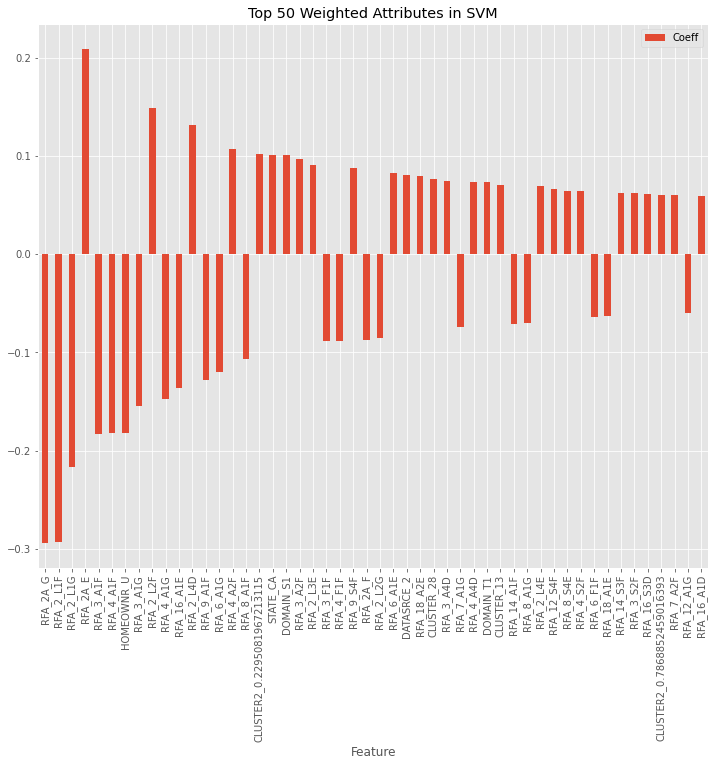

In [30]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#weights = pd.Series(lr_clf.coef_[0],index=final_df.columns)
zip_vars_df2.sort_values(by=['Abs_Coeff'], ascending = False).head(50).plot(x = 'Feature', y = 'Coeff', kind='bar',
                                            figsize= (12,10), title = "Top 50 Weighted Attributes in SVM")
plt.show()

From above, we can see that the top 5 most influential attributes are: RFA_2A_G, RFA_2A_E, RFA_2_L1F, RFA_2A_F, and RFA_2_L1G.

In [31]:
df_tested_on = scaled_subset.iloc[train_indices2].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['TARGET'] = y_sub[svm_clf.support_] # add back in the 'Target' Column to the pandas dataframe
scaled_subset['TARGET'] = y_sub # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7677 entries, 15991 to 83701
Columns: 1399 entries, TCODE_1 to GEOCODE2_D
dtypes: float64(1398), uint8(1)
memory usage: 81.9 MB


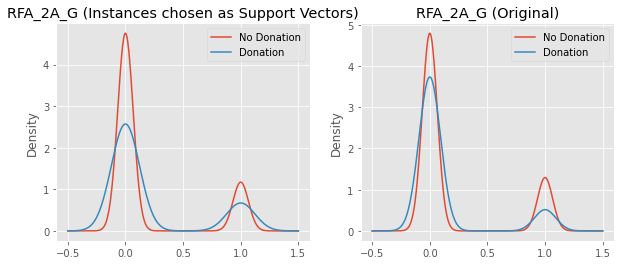

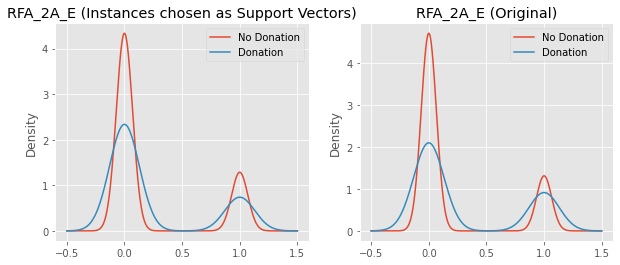

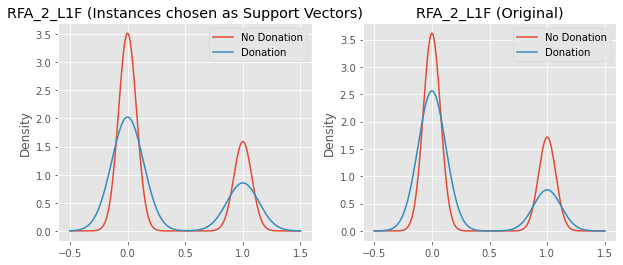

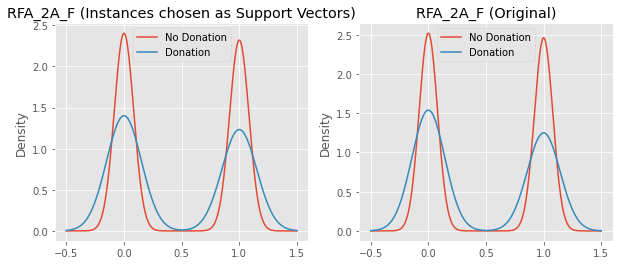

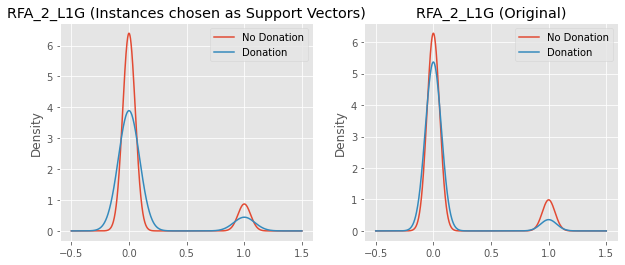

In [32]:
#Visualize statistics for important attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['TARGET'])
df_grouped = scaled_subset.groupby(['TARGET'])

# plot KDE of Different variables
vars_to_plot = ['RFA_2A_G', 'RFA_2A_E', 'RFA_2_L1F', 'RFA_2A_F','RFA_2_L1G']
for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['No Donation','Donation'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['No Donation','Donation'])
    plt.title(v+' (Original)')

The graphs above show the distribution of the instances that were chosen as support vectors and those in the original dataset. The instances that were chosen as support vectors are supposed to have almost identical distributions between the two donation classes. This is because support vectors are chosen based on instances that are on the edge of the defining boundaries; however, that is not the case for our dataset. This is likely because our dataset is so large, the subset used to train the true support vector model is not representative of the entire dataset. In addition, there is likely not good linear separation between the two classes, making it difficult to draw hyperplanes for accurate classification.